## Preamble

Install [aeon](https://www.aeon-toolkit.org/) package. This is a toolkit for machine learning on time series.

In [81]:
!pip install aeon

Import libraries.

In [82]:
import numpy as np
from numpy import linalg as LA    # norm function

from matplotlib.pyplot import subplots
from matplotlib.collections import LineCollection   # color line segments
from matplotlib import cm, colors                   # colormaps and colorbar


from aeon.datasets import load_classification   # dataset import

# time series plots
from aeon.visualisation import (
    plot_series,
    plot_series_collection,
    plot_collection_by_class,
)

# distance based method
from aeon.distances import dtw_distance
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier


from sklearn import metrics   # accuracy_score function

# RNN
import tensorflow as tf
from tensorflow import keras

Initialize random generator.

In [83]:
rng = np.random.default_rng(seed=2025)

## Load data

Since, at the time of writing, the [official repo](https://www.timeseriesclassification.com/description.php?Dataset=EigenWorms) for the dataset was not available, we use aeon import function to get the data.

In [84]:
X_train, y_train = load_classification("EigenWorms", split="train")
X_test , y_test  = load_classification("EigenWorms", split="test" )

## Data inspection

Print and define variables for dimensions.

In [85]:
print("shape \t train \t\t\t test")
print(f"  X \t {X_train.shape} \t {X_test.shape}")
print(f"  y \t {y_train.shape} \t\t {y_test.shape}")

shape 	 train 			 test
  X 	 (128, 6, 17984) 	 (131, 6, 17984)
  y 	 (128,) 		 (131,)


In [86]:
n_cases, n_channels, n_timepoints = X_train.shape
n_test_cases  = X_test.shape[0]
n_classes     = np.unique(y_train).size

Plot a sample's channels (features), that is the time series associated to each _eigenworm_.

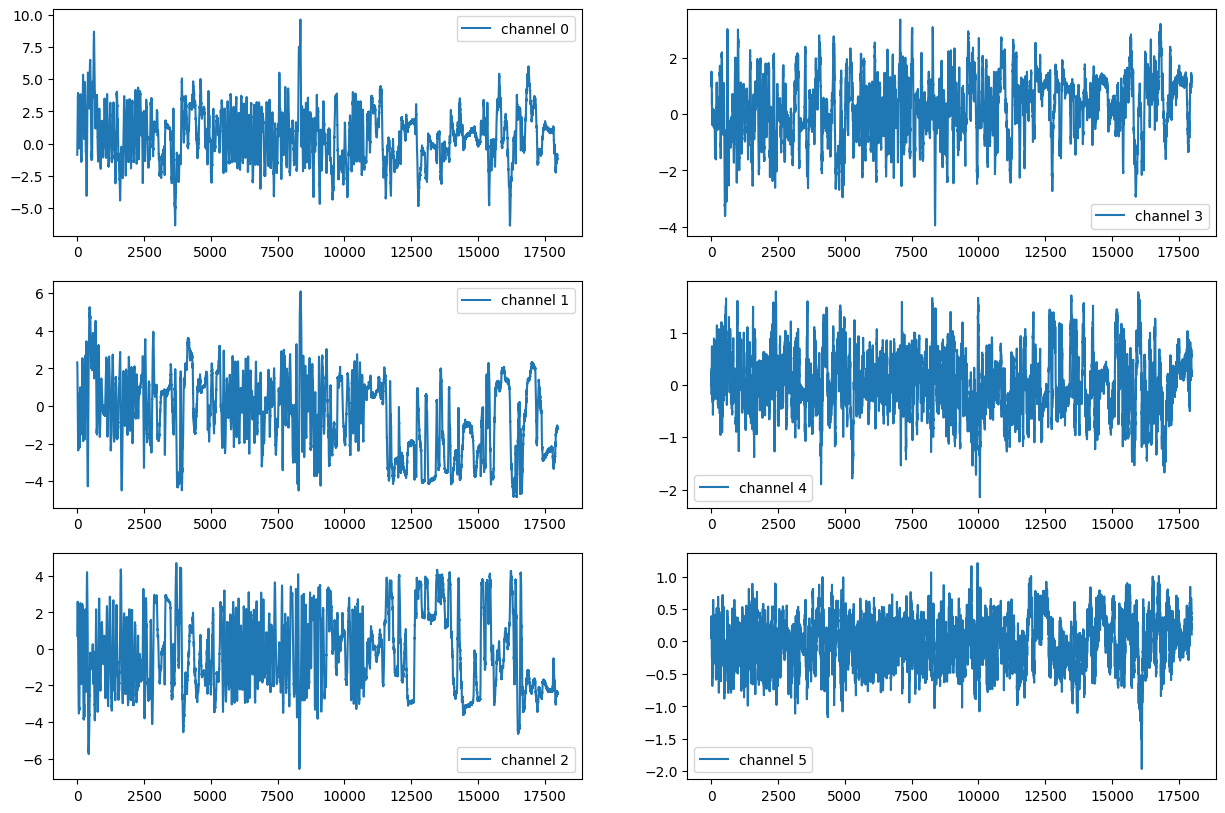

In [87]:
x = X_train[0]

fig, ax = subplots(nrows=3, ncols=2, figsize=(15,10))
for i in range(3):
  for j in range(2):
    ax[i,j].plot(x[i+3*j], label=f"channel {i+3*j}")
    ax[i,j].legend()

fig.show()

We can see the time series are very long. Even though the length is uniform across channels, there is a lot of variability in the scale.

This is true also across samples.

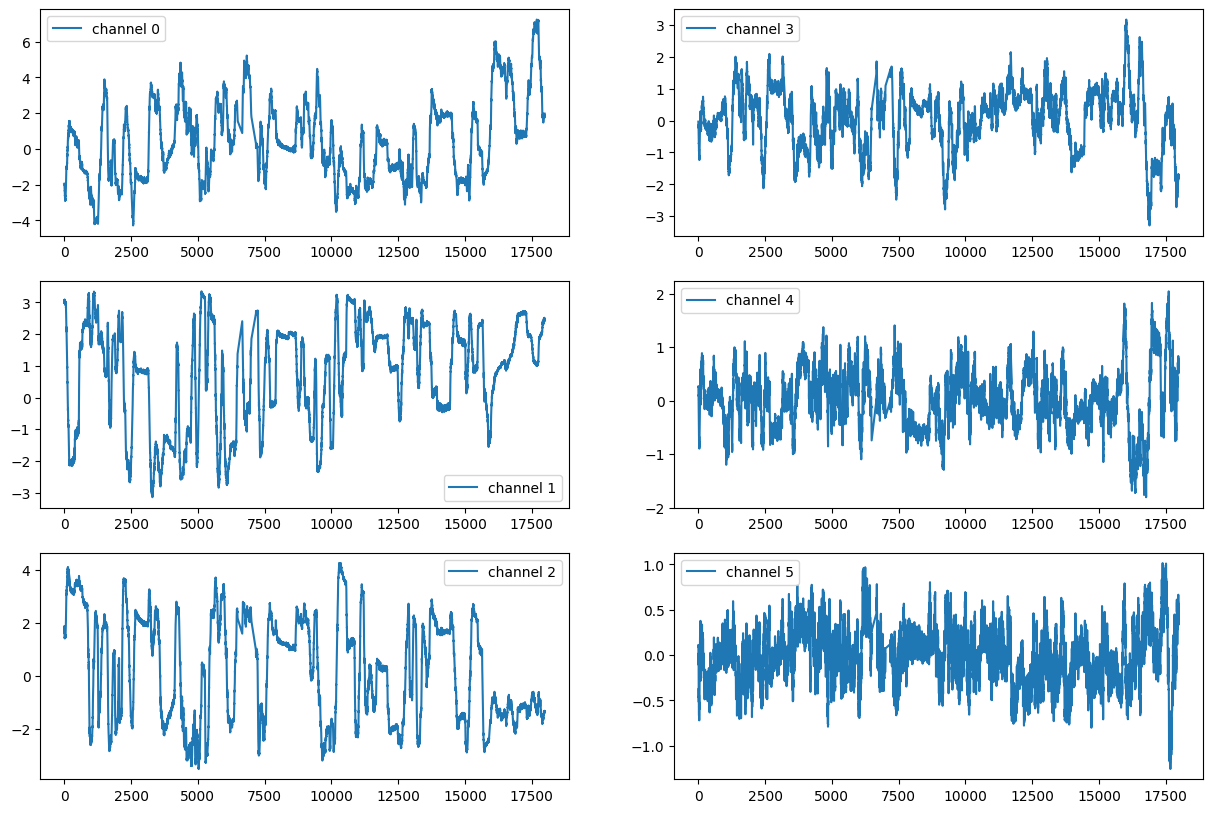

In [88]:
x = X_train[1]

fig, ax = subplots(nrows=3, ncols=2, figsize=(15,10))
for i in range(3):
  for j in range(2):
    ax[i,j].plot(x[i+3*j], label=f"channel {i+3*j}")
    ax[i,j].legend()

fig.show()

We also see quite different shapes for samples that should belong to the same class.

In [89]:
print(y_train[0], y_train[1])

1 1


## Distances + KNN

### Downsampling

Computing distances with such long time series is quite expensive, so we downsample by skipping timesteps.

In [90]:
step = 64   # length skip

X_train_reduced = X_train[:, :, ::step]   # take 1 out of `step` elements
X_test_reduced  = X_test [:, :, ::step]

print(X_train_reduced.shape)

(128, 6, 281)


Compare the original and the downsampled version.

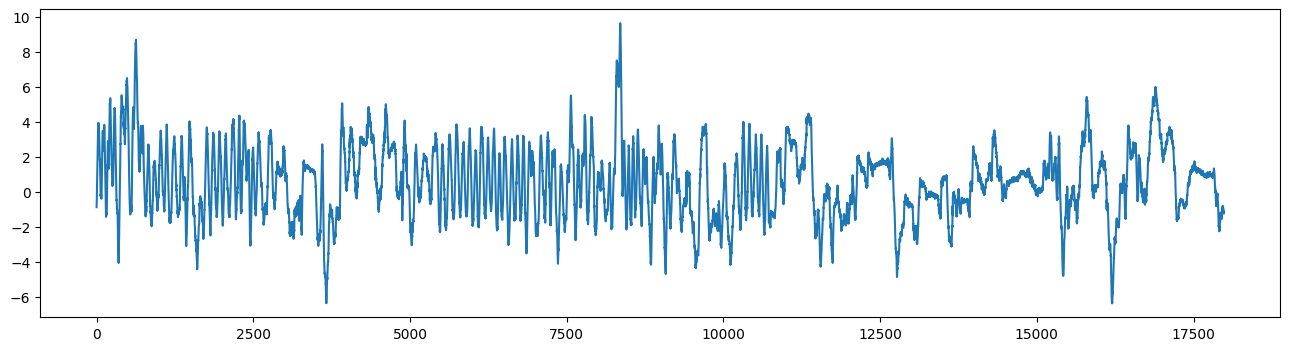

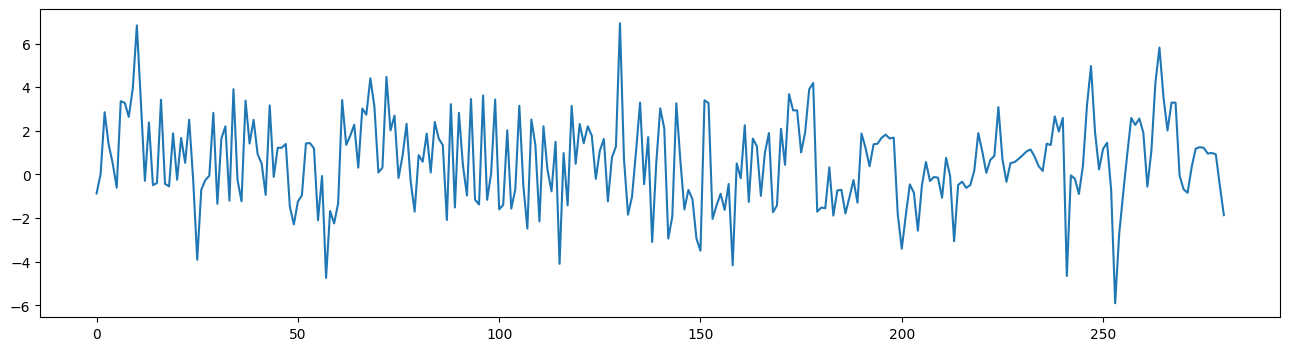

In [91]:
_ = plot_series_collection(X_train        [[0], 0, :])
_ = plot_series_collection(X_train_reduced[[0], 0, :])

Notice that we have not only reduced the number of timesteps, but also the scale changed (especially nearby the narrow spikes). \
However, qualitatively the shape is pretty similar. We got rid of the higher frequencies (the small jitter, likely due to noise) and kept the general behaviour of the time series.

### Classify

Compute time series distances and use them as features to fit a KNN classifier.

The distance chosen is Dynamic Time Warping, a common elastic distance, more suited for time series than euclidean. \
Notice that in order to reduce computational load, we use a bounding window to compute the warping path.

We also use weighted nearest neighbour. Unlike the uniform version where a majority vote is used and all the votes are the same, now we give a weight to each vote based on the distance from the test sample: closer points have more weight than those further away.

In [92]:
k = n_classes

knn = KNeighborsTimeSeriesClassifier(
    n_neighbors     = k,
    weights         = 'distance',
    distance        = 'dtw',
    distance_params = {'window': 0.2},
)
knn.fit(X_train_reduced, y_train)

knn_preds = knn.predict(X_test_reduced)
acc = metrics.accuracy_score(y_test, knn_preds)

print(f"k = {k} \t accuracy = {acc}")

k = 5 	 accuracy = 0.5954198473282443


### Feature occlusion (class)

Perform feature occlusion on the predicted class.

We zero-out one of the channels at a time and predict on the occluded test sample. \
The more the accuracy drops, the more important the feature.

In [93]:
for c in range(n_channels):
  X_occluded = X_test_reduced.copy()    # pass by copy to avoid changing the original
  X_occluded[:,c,:] = 0                 # zero-out all samples, all timesteps, channel c

  knn_preds = knn.predict(X_occluded)
  acc = metrics.accuracy_score(y_test, knn_preds)
  print(f"channel = {c} \t accuracy = {acc}")

channel = 0 	 accuracy = 0.29770992366412213
channel = 1 	 accuracy = 0.48091603053435117
channel = 2 	 accuracy = 0.48854961832061067
channel = 3 	 accuracy = 0.5572519083969466
channel = 4 	 accuracy = 0.5877862595419847
channel = 5 	 accuracy = 0.5954198473282443


Since the class predicted is unreliable for sensitivity analysis (see report), we perform again feature occlusion but evaluated on the class probability vectors.

First of all, take a look at the probability vectors.

In [94]:
# compute probability vector instead of class prediction
class_probs = knn.predict_proba(X_test_reduced)

print(knn.classes_)           # returns the labels in the array position
print(np.array_str(
    class_probs[:15],         # first rows
    precision       = 2,      # use 2 decimal digits
    suppress_small  = True    # don't use exponential notation
))

['1' '2' '3' '4' '5']
[[0.61 0.19 0.   0.2  0.  ]
 [1.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.  ]
 [0.6  0.4  0.   0.   0.  ]
 [0.79 0.   0.21 0.   0.  ]
 [1.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.  ]
 [0.79 0.   0.   0.21 0.  ]
 [0.8  0.2  0.   0.   0.  ]
 [0.8  0.2  0.   0.   0.  ]
 [0.79 0.21 0.   0.   0.  ]
 [1.   0.   0.   0.   0.  ]
 [0.8  0.2  0.   0.   0.  ]
 [0.6  0.21 0.19 0.   0.  ]]


Now compute the probability vectors for the occluded versions.

In [95]:
class_probs_occluded = {c : [] in range(n_channels)}

for c in range(n_channels):
  X_occluded = X_test_reduced.copy()
  X_occluded[:,c,:] = 0

  class_probs_occluded[c] = knn.predict_proba(X_occluded)

And finally compute the euclidean distance between the vectors. \
Again, higher distances mean the prediction is more sensitive to the occluded feature.

In [96]:
probs_distances = {c : [] for c in range(n_channels)}

for c in range(n_channels):
  X_occluded = X_test_reduced.copy()
  X_occluded[:,c,:] = 0

  probs_distances[c] = LA.norm(class_probs - class_probs_occluded[c], axis=1)

We can make a plot to visualize better the result.

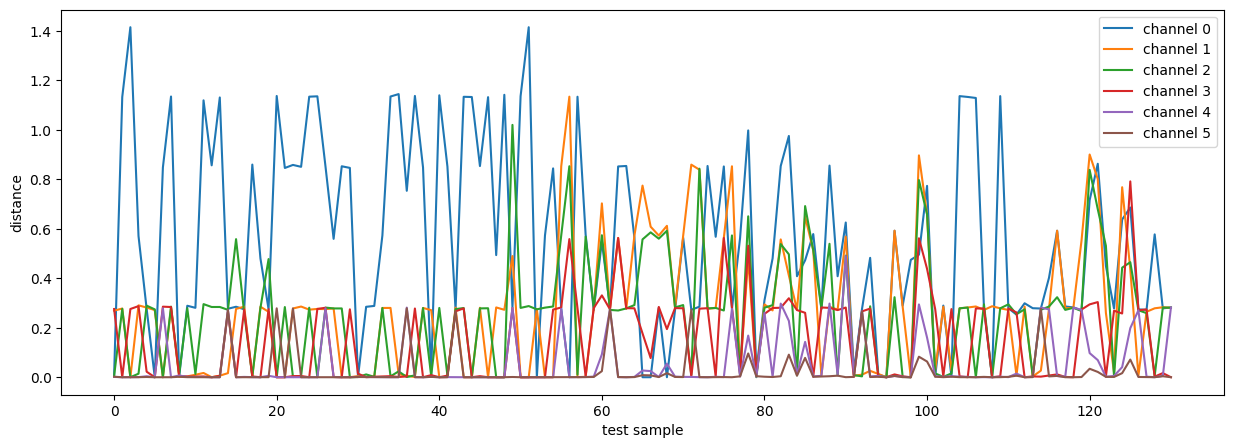

In [97]:
fig, ax = subplots(figsize=(15,5))

for c in range(n_channels):
  ax.plot(probs_distances[c], label=f"channel {c}")

ax.set_xlabel("test sample")
ax.set_ylabel("distance")
ax.legend()

fig.show()

Or sum across the samples to get a single estimate.

In [98]:
for c in range(n_channels):
  print(f"{probs_distances[c].sum()  : >10.4f}")

   73.6036
   35.2461
   33.7305
   19.6935
    7.2479
    3.1711


Notice that we haven't rescaled the channels, so it may be unwise to draw conclusions yet.

## RNN

We examine how a model with an inductive bias for time series, namely a RNN, can perform.

### Setup

Define attention layer to perform the attribution. \
The job of this layer is to learn which parts of the sequence are more important for the final prediction by assigning weights to each timestep.

In [99]:
class BahdanauAttention(keras.layers.Layer):

  def __init__(self, units):
    super().__init__()
    self.W1 = keras.layers.Dense(units, use_bias=False)
    self.W2 = keras.layers.Dense(units, use_bias=False)
    self.V  = keras.layers.Dense(1)

  def call(self, query, values):
    '''
    The forward pass of the attention layer.

    Args:
      query: The final hidden state of the LSTM (decoder state).
              Shape: (batch_size, hidden_units)
      values: All the hidden states from the LSTM (encoder outputs).
              Shape: (batch_size, sequence_length, hidden_units)

    Returns:
      context_vector: The weighted sum of the values.
                      Shape: (batch_size, hidden_units)
      attention_weights: The weights showing the focus of the model.
    '''
    # Expand query to be broadcastable with values
    # Shape becomes: (batch_size, 1, hidden_units)
    query_with_time_axis = tf.expand_dims(query, 1)

    # Calculate the alignment score (energy)
    # V * tanh(W1*values + W2*query)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))

    # Normalize scores to get attention weights (probabilities)
    attention_weights = tf.nn.softmax(score, axis=1)

    # Calculate the context vector as the weighted sum of values
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

Define function to plot the time series colored according to the attention weights.

In [100]:
def color_segments(x, y, intensity):
  ''' Returns line collection of segments colored according to the intensity vector. '''

  points   = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)

  lc = LineCollection(
      segments,
      cmap  = "plasma",
      array = intensity
  )
  return lc


def plot_attention(X, attention_w):
  '''
  X.shape = (n_samples, n_timesteps, 1)
  attention_w.shape = (n_samples, n_timesteps)
  '''

  length = X.shape[1]

  lc = color_segments(
      range(length),
      X.squeeze(),
      attention_w.squeeze()
  )

  fig, ax = subplots()
  ax.add_collection(lc)
  ax.autoscale()

  cbar = fig.colorbar(lc, ax=ax)
  cbar.set_label("attention weights")

  return fig, ax, cbar

### Univariate

First we try the univariate version.

We do a little pre-processing to the data. \
Notice that in principle the order of the operations may influence the final outcome (although it shouldn't be too significant).

X_train shape:  (128, 843, 1)
y_train:  [4 0 1 0 0 1 0 3 0 1 4 2 2 0 0 0 0 0 4 3 3 0 1 1 0 0 2 0 3 3 3 4 0 2 0 0 0
 4 1 3 1 2 3 0 2 2 2 0 1 2 0 2 2 3 0 0 0 4 0 0 1 4 1 0 4 3 0 0 1 0 0 1 3 0
 2 0 0 1 3 0 2 1 4 4 4 3 0 1 1 3 0 1 4 2 0 0 2 0 1 3 1 0 3 3 3 1 0 1 0 0 0
 0 0 0 0 0 1 3 2 0 0 0 3 0 3 0 3 2]


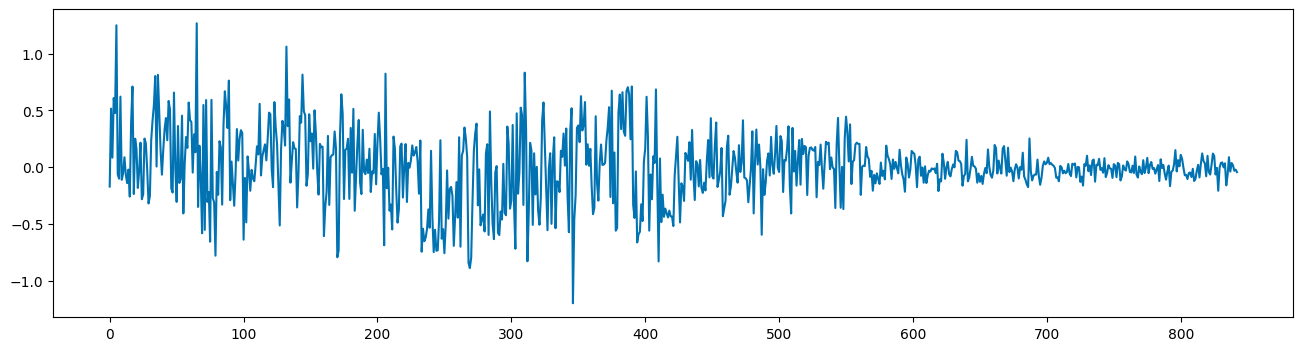

In [101]:
# concatenate all the channels in a mega time series
X_train_uni = X_train.reshape(n_cases     , -1)
X_test_uni  = X_test .reshape(n_test_cases, -1)

# normalize the data
train_mean = X_train_uni.mean()
train_std  = X_train_uni.std()
X_train_normalized = (X_train_uni - train_mean) / train_std
X_test_normalized  = (X_test_uni  - train_mean) / train_std

# downsample
step = 128
X_train_reduced = X_train_normalized[:, ::step]
X_test_reduced  = X_test_normalized [:, ::step]

# re-add dimension to agree with keras API
X_train_RNN = X_train_reduced[:, :, np.newaxis]
X_test_RNN  = X_test_reduced [:, :, np.newaxis]

print("X_train shape: ", X_train_RNN.shape)
_ = plot_series(X_train_RNN[0], markers=' ')


# convert labels to numerical values and 0-indexed
y_train_num = y_train.astype(int) - 1
y_test_num  = y_test .astype(int) - 1


# shuffle training set
perm = rng.permutation(n_cases)
X_train_RNN = X_train_RNN[perm]
y_train_num = y_train_num[perm]

print("y_train: ", y_train_num)

Define all the hyperparameters and the network architecture. \
We try to keep it as simple as possible.

Notice that we actually build two models (albeit they share parameters, so we train only one): one outputs only predictions, the other also the attention weights. This is a just a workaround to get to print aftwerwards the weights to plot (I didn't manage to do it in one model).

At the end we train the model, with validation to check eventual under/overfitting during training.

In [102]:
MAX_LENGTH    = X_train_RNN.shape[1]
NUM_FEATURES  = 1
RNN_UNITS     = 64
ATT_UNITS     = RNN_UNITS*2
NUM_CLASSES   = n_classes
NUM_EPOCHS    = 10
BATCH_SIZE    = 8


# input layer
inputs = keras.Input(shape=(MAX_LENGTH, NUM_FEATURES))

# lstm layer
lstm, forward_h, forward_c, backward_h, backward_c = \
  keras.layers.Bidirectional(   # wrap in bidirectional layer
    keras.layers.LSTM(
        RNN_UNITS,
        return_sequences  = True,   # get output for each time step
        return_state      = True,   # get the final hidden and cell states
    )
  )(inputs)
state_h = keras.layers.Concatenate()([forward_h, backward_h])

# attention layer
attention_layer = BahdanauAttention(ATT_UNITS)
context_vector, attention_weights = attention_layer(state_h, lstm)

# final layer
final_output = keras.layers.Dense(
    NUM_CLASSES,
    activation  = 'softmax'   # to get probability vectors
)(context_vector)


train_model = keras.Model(
    inputs  = inputs,
    outputs = final_output
)

dual_model = keras.Model(
    inputs  = inputs,
    outputs = [final_output, attention_weights]
)


train_model.compile(
    optimizer = 'adam',
    loss      = 'sparse_categorical_crossentropy',    # for classification on integer labels
    metrics   = ['accuracy']
)

print(train_model.summary(), "\n")


train_model.fit(
    X_train_RNN,
    y_train_num,
    epochs      = NUM_EPOCHS,
    batch_size  = BATCH_SIZE,
    validation_split = 0.2
);

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 843, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ [(None, 843,      │     33,792 │ input_layer_4[0]… │
│ (Bidirectional)     │ 128), (None, 64), │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ bidirectional_4[… │
│ (Concatenate)       │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ [(None, 128),     │     32,897 │ concatenate_4[0]… │
│ (BahdanauAttention) │ (None, 843, 1)]   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 5)         │        645 │ bahdanau_attenti… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,334 (263.02 KB)

 Trainable params: 67,334 (263.02 KB)

 Non-trainable params: 0 (0.00 B)

None 

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 491ms/step - accuracy: 0.3462 - loss: 1.6023 - val_accuracy: 0.5385 - val_loss: 1.5393
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - accuracy: 0.4150 - loss: 1.5426 - val_accuracy: 0.5385 - val_loss: 1.3457
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 530ms/step - accuracy: 0.4447 - loss: 1.4381 - val_accuracy: 0.5000 - val_loss: 1.4326
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - accuracy: 0.4791 - loss: 1.4011 - val_accuracy: 0.4615 - val_loss: 1.4141
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 554ms/step - accuracy: 0.4421 - loss: 1.3337 - val_accuracy: 0.4231 - val_loss: 1.5238
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 558ms/step - accuracy: 0.4468 - loss: 1.4133 - val_accuracy: 0.5385 - val_loss: 1.4424
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.4560 - loss: 1.3239 - val_accuracy: 0.5000 - val_loss: 1.4022
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - accuracy: 0.4716 - loss: 1.3123 - val_a

Try to predict on a single sample and plot the attention weights.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
Final Prediction: [0.51246476 0.30691767 0.04489821 0.09896752 0.03675195]
True class: 0
Shape of attention weights: (1, 843, 1)


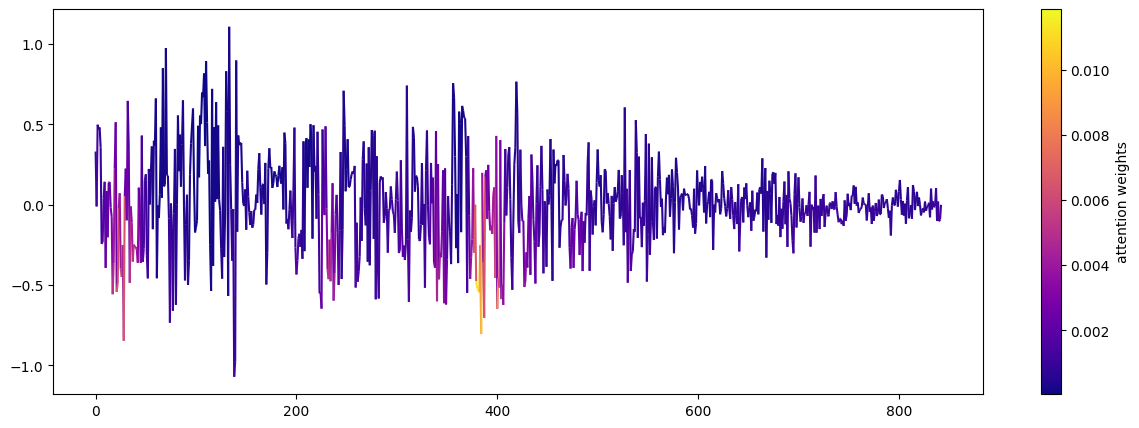

In [103]:
test_sample = X_test_RNN[[0]]
predictions, attention_w = dual_model.predict(test_sample)

print(f"Final Prediction: {predictions[0]}")
print(f"True class: {y_test_num[0]}")
print(f"Shape of attention weights: {attention_w.shape}")

fig, ax, _ = plot_attention(test_sample, attention_w)
fig.set_size_inches(15, 5)
fig.show()

Seems to work well!

Now check predictions on the training samples for each class \[full screen for best view\].

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Final Prediction (sample  1, class 0): [0.5161766  0.24989586 0.06287163 0.11988211 0.05117383]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Final Prediction (sample  2, class 1): [0.47069913 0.18104531 0.10725363 0.15486363 0.08613838]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Final Prediction (sample 11, class 2): [0.26971823 0.06259618 0.25649315 0.19894908 0.21224335]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Final Prediction (sample  7, class 3): [0.51039505 0.32767782 0.03892318 0.09105455 0.03194932]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Final Prediction (sample  0, class 4): [0.24476391 0.05683978 0.26763156 0.21010546 0.22065927]


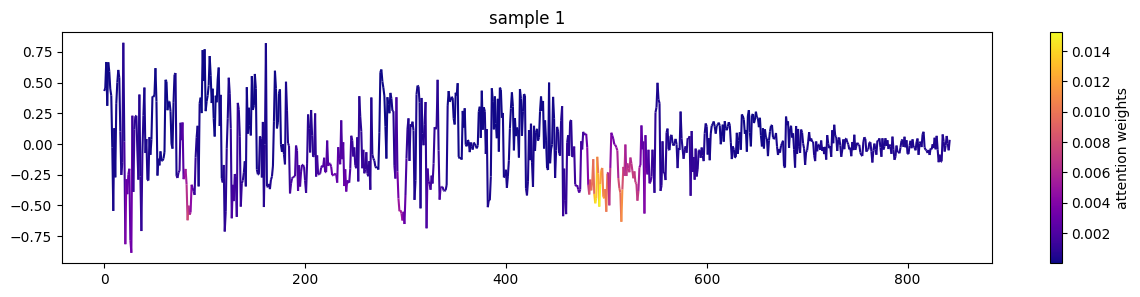

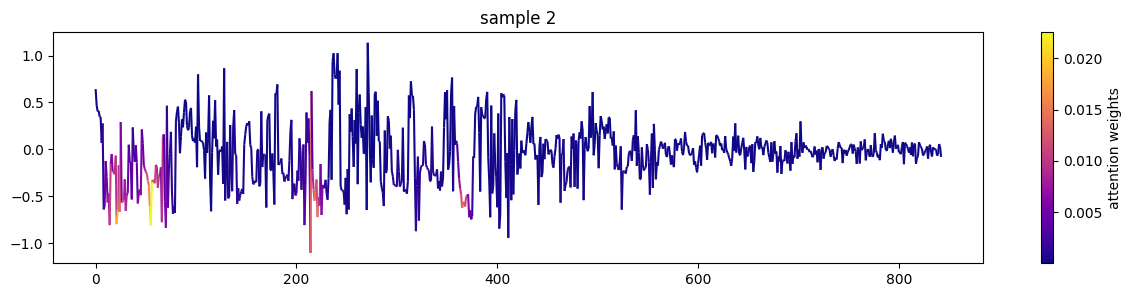

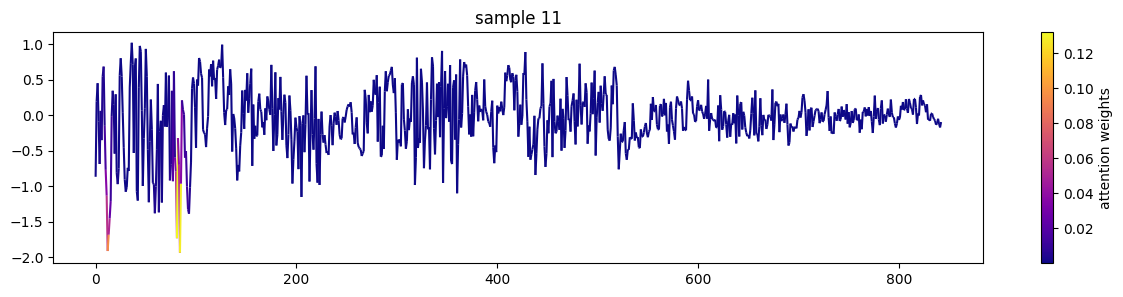

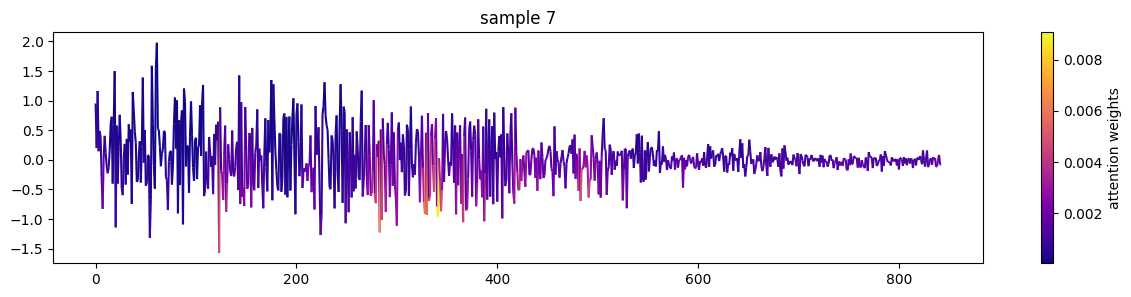

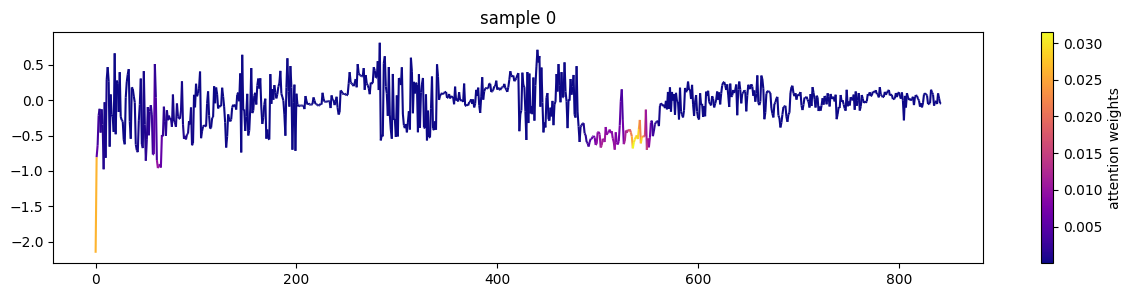

In [104]:
_, first_idx = np.unique(y_train_num, return_index=True)    # get indices of first unique appearance of class labels (sorted)
for idx in first_idx:
  test_sample = X_train_RNN[[idx]]
  predictions, attention_w = dual_model.predict(test_sample)

  print(f"Final Prediction (sample {idx : >2}, class {y_train_num[idx]}): {predictions[0]}")

  fig, ax, _ = plot_attention(test_sample, attention_w)
  fig.set_size_inches(15, 3)
  ax.set_title(f"sample {idx}")
  fig.show()

A good model should (at least) be able to correctly classify on (most) of the training set. \
Our model is a bit quirky, since predictions lean more heavily on the first class regardless of the true class. This may be caused by class inbalance in the training set.

Check accuracy on all samples.

In [105]:
print("loss/accuracy on training set: ", train_model.evaluate(X_train_RNN, y_train_num) )
print("loss/accuracy on test set    : ", train_model.evaluate(X_test_RNN , y_test_num ) )

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.4854 - loss: 1.2557
loss/accuracy on training set:  [1.2500368356704712, 0.4921875]
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.6426 - loss: 1.0993
loss/accuracy on test set    :  [1.2780907154083252, 0.4656488597393036]


Overall not very impressive.

### Multivariate

In the multivariate version we pass a vector of features, so we don't need to concatenate. For this reason we can allow a less aggressive downsample. We also skip rescaling this time.

In [106]:
# downsample
step = 32
X_train_reduced = X_train[:, :, ::step]
X_test_reduced  = X_test [:, :, ::step]

# swap dimensions to agree with keras API
X_train_RNN = X_train_reduced.transpose(0, 2, 1)
X_test_RNN  = X_test_reduced .transpose(0, 2, 1)

print("X_train shape: ", X_train_RNN.shape)


# convert labels to numerical values and 0-indexed
y_train_num = y_train.astype(int) - 1
y_test_num  = y_test .astype(int) - 1


# shuffle data
perm = rng.permutation(n_cases)
X_train_RNN = X_train_RNN[perm]
y_train_num = y_train_num[perm]

print("y_train: ", y_train_num)

X_train shape:  (128, 562, 6)
y_train:  [4 0 3 0 0 3 0 0 3 0 3 0 0 1 0 4 0 0 0 3 2 2 0 4 1 2 3 2 1 2 0 1 2 1 4 0 2
 3 3 0 0 0 2 0 2 0 4 3 0 2 0 0 0 3 0 0 3 3 0 1 3 4 0 0 1 1 0 0 3 3 0 0 0 3
 0 0 0 1 0 0 2 4 3 0 0 1 1 4 3 0 1 1 0 2 0 1 1 1 2 0 2 0 1 4 0 1 0 0 1 3 0
 0 1 3 0 2 2 0 4 2 0 3 3 4 0 1 4 1]


We use the same exact code as before with the only difference that this time `NUM_FEATURES` is not 1.

We should probably modify the class for the attention layer in a way to distribute weights across the multiple entries of the features vector, if we want to make a reasonable plot. For time constraints, we don't implement this and just re-use the univariate version.

In [107]:
MAX_LENGTH    = X_train_RNN.shape[1]
NUM_FEATURES  = n_channels
RNN_UNITS     = 64
ATT_UNITS     = RNN_UNITS*2
NUM_CLASSES   = n_classes
NUM_EPOCHS    = 10
BATCH_SIZE    = 8


inputs = keras.Input(shape=(MAX_LENGTH, NUM_FEATURES))

lstm, forward_h, forward_c, backward_h, backward_c = \
  keras.layers.Bidirectional(
    keras.layers.LSTM(
        RNN_UNITS,
        return_sequences  = True,
        return_state      = True,
        # dropout           = 0.2,
        # recurrent_dropout = 0.2
    )
  )(inputs)
state_h = keras.layers.Concatenate()([forward_h, backward_h])

attention_layer = BahdanauAttention(ATT_UNITS)
context_vector, attention_weights = attention_layer(state_h, lstm)

final_output = keras.layers.Dense(
    NUM_CLASSES,
    activation  = 'softmax'
)(context_vector)


train_model = keras.Model(
    inputs  = inputs,
    outputs = final_output
)

dual_model = keras.Model(
    inputs  = inputs,
    outputs = [final_output, attention_weights]
)


train_model.compile(
    optimizer = 'adam',
    loss      = 'sparse_categorical_crossentropy',
    metrics   = ['accuracy']
)

print(train_model.summary(), "\n")


train_model.fit(
    X_train_RNN,
    y_train_num,
    epochs      = NUM_EPOCHS,
    batch_size  = BATCH_SIZE,
    validation_split = 0.2
);

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 562, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ [(None, 562,      │     36,352 │ input_layer_5[0]… │
│ (Bidirectional)     │ 128), (None, 64), │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128)       │          0 │ bidirectional_5[… │
│ (Concatenate)       │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ [(None, 128),     │     32,897 │ concatenate_5[0]… │
│ (BahdanauAttention) │ (None, 562, 1)]   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 5)         │        645 │ bahdanau_attenti… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,894 (273.02 KB)

 Trainable params: 69,894 (273.02 KB)

 Non-trainable params: 0 (0.00 B)

None 

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.2454 - loss: 1.5915 - val_accuracy: 0.3462 - val_loss: 1.5504
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.4670 - loss: 1.4505 - val_accuracy: 0.3462 - val_loss: 1.5854
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.4335 - loss: 1.3957 - val_accuracy: 0.4231 - val_loss: 1.4428
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - accuracy: 0.4497 - loss: 1.3511 - val_accuracy: 0.4231 - val_loss: 1.3070
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.5315 - loss: 1.1082 - val_accuracy: 0.4231 - val_loss: 1.1419
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - accuracy: 0.5971 - loss: 0.9897 - val_accuracy: 0.6154 - val_loss: 0.9775
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.6059 - loss: 0.9078 - val_accuracy: 0.6538 - val_loss: 0.8915
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.6945 - loss: 0.7586 - val_accur

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Final Prediction: [0.6363344  0.14188252 0.0574744  0.1328944  0.03141429]
True class: 0
Shape of attention weights: (1, 562, 1)


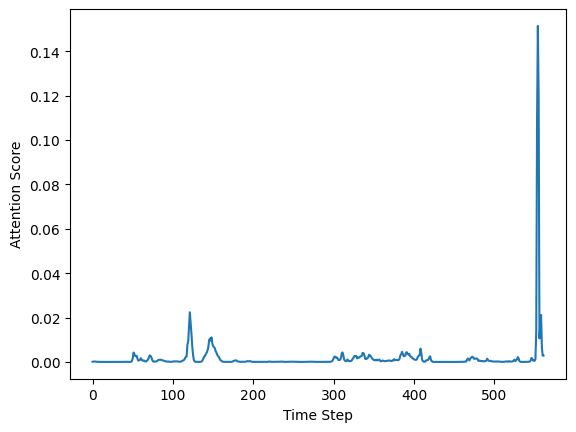

In [108]:
test_sample = X_test_RNN[[0]]
predictions, attention_w = dual_model.predict(test_sample)

print(f"Final Prediction: {predictions[0]}")
print(f"True class: {y_test_num[0]}")
print(f"Shape of attention weights: {attention_w.shape}")

fig, ax = subplots()
ax.plot(attention_w.squeeze())
ax.set_xlabel("Time Step")
ax.set_ylabel("Attention Score")
fig.show()

In [109]:
_, first_idx = np.unique(y_train_num, return_index=True)    # get indices of first unique appearance of class labels (sorted)
for idx in first_idx:
  test_sample = X_train_RNN[[idx]]
  predictions, attention_w = dual_model.predict(test_sample)

  print(f"Final Prediction (sample {idx : >2}, class {y_train_num[idx]}): {predictions[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Final Prediction (sample  1, class 0): [0.85041505 0.11800315 0.00364131 0.02162371 0.00631681]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Final Prediction (sample 13, class 1): [0.1461086  0.8345651  0.00195131 0.00961598 0.00775893]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Final Prediction (sample 20, class 2): [0.03849139 0.1290387  0.7930074  0.01622011 0.02324244]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Final Prediction (sample  2, class 3): [0.17519575 0.02507585 0.07714126 0.5804227  0.14216438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Final Prediction (sample  0, class 4): [0.28000027 0.41072753 0.01276087 0.19530736 0.10120394]


We see much more sharp (and accurate) predictions respect to the univariate version ...

In [110]:
print("loss/accuracy on training set: ", train_model.evaluate(X_train_RNN, y_train_num) )
print("loss/accuracy on test set    : ", train_model.evaluate(X_test_RNN , y_test_num ) )

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.8219 - loss: 0.4899
loss/accuracy on training set:  [0.5325594544410706, 0.8046875]
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6793 - loss: 0.8916
loss/accuracy on test set    :  [1.0551848411560059, 0.6106870174407959]


... and the overall accuracy is not as bad (although we should make additional checks for overfitting).